### Step 0: Import Dependencies

In [1]:
from fastcore.all import *
from fastai.vision.all import *


In [2]:
torch.cuda.is_available()

False

In [3]:
# This code is only here to check that your internet is enabled. It doesn't do anything else.

import socket,warnings
try:
    socket.setdefaulttimeout(5)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

### Step 1: Download Pictures of Trash and Art

In [4]:
from duckduckgo_search import DDGS #ddg_images


def search_images(term, max_images=60):
    print(f"Searching for '{term}'")
    return L(DDGS().images(term, max_results=max_images)).itemgot('image')

In [5]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('glass waste', max_images=1)
print(len(urls))
urls[0]

Searching for 'glass waste'
1


'https://www.leeglass.com/wp-content/uploads/2019/08/iStock-1081866910.jpg'

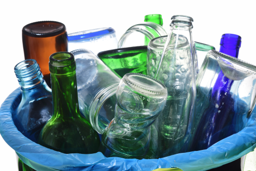

In [6]:
from fastdownload import download_url
dest = 'test_pictures/glass_waste.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256) 

In [5]:
categories  = ['scrap paper', 'scrap metal', 'waste plastic', 'food scraps', 'scrap wood',
               'visual art', 'pottery', 'wooden furniture', 'jewelery', 'plastic toy']

In [8]:
for i in categories:
    download_url(search_images(f'{i}', max_images=1)[0], f'test_pictures/{i}.jpg', show_progress=False)

Searching for 'scrap paper'
Searching for 'scrap metal'
Searching for 'waste plastic'
Searching for 'food scraps'
Searching for 'scrap wood'
Searching for 'visual art'
Searching for 'pottery'
Searching for 'wooden furniture'
Searching for 'jewelery'
Searching for 'plastic toy'


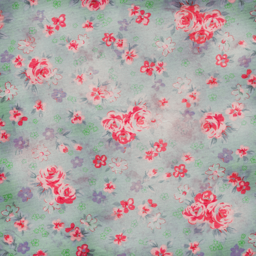

In [9]:
Image.open('test_pictures/scrap paper.jpg').to_thumb(256,256)

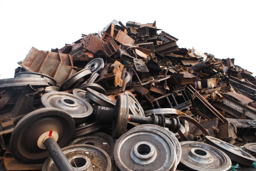

In [10]:
Image.open('test_pictures/scrap metal.jpg').to_thumb(256,256)

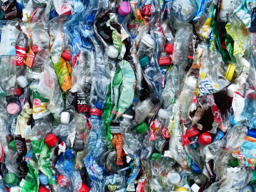

In [11]:
Image.open('test_pictures/waste plastic.jpg').to_thumb(256,256)

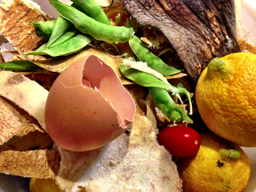

In [12]:
Image.open('test_pictures/food scraps.jpg').to_thumb(256,256)

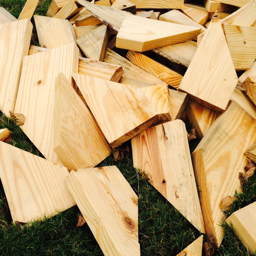

In [13]:
Image.open('test_pictures/scrap wood.jpg').to_thumb(256,256)

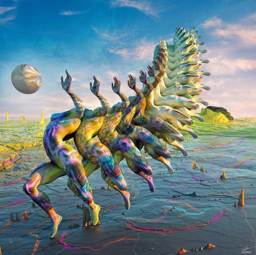

In [14]:
Image.open('test_pictures/visual art.jpg').to_thumb(256,256)

In [15]:
Image.open('test_pictures/pottery.jpg').to_thumb(256,256)

UnidentifiedImageError: cannot identify image file 'test_pictures/pottery.jpg'

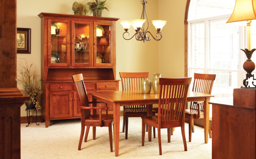

In [16]:
Image.open('test_pictures/wooden furniture.jpg').to_thumb(256,256)

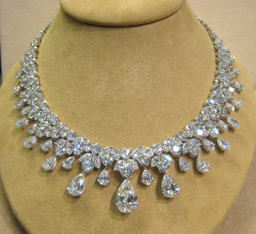

In [17]:
Image.open('test_pictures/jewelery.jpg').to_thumb(256,256)

In [6]:
categories.append('glass waste')

In [7]:
searches = categories
path = Path('train_images')

In [21]:
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'scrap paper'
Searching for 'scrap metal'
Searching for 'waste plastic'
Searching for 'food scraps'
Searching for 'scrap wood'
Searching for 'visual art'
Searching for 'pottery'
Searching for 'wooden furniture'
Searching for 'jewelery'
Searching for 'plastic toy'
Searching for 'glass waste'


### Step 2: Model Training

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

c:\Users\katle\anaconda3\envs\dl_env\Lib\site-packages\fastai\torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


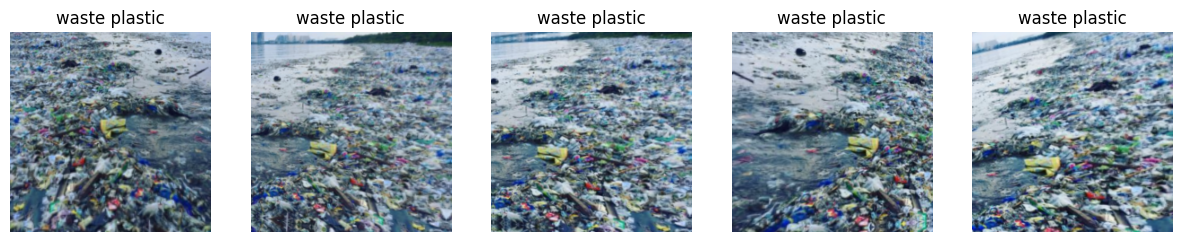

In [9]:
art_or_trash = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.25, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
).dataloaders(path, bs=32)

art_or_trash.train.show_batch(max_n=5, nrows=1, unique=True)

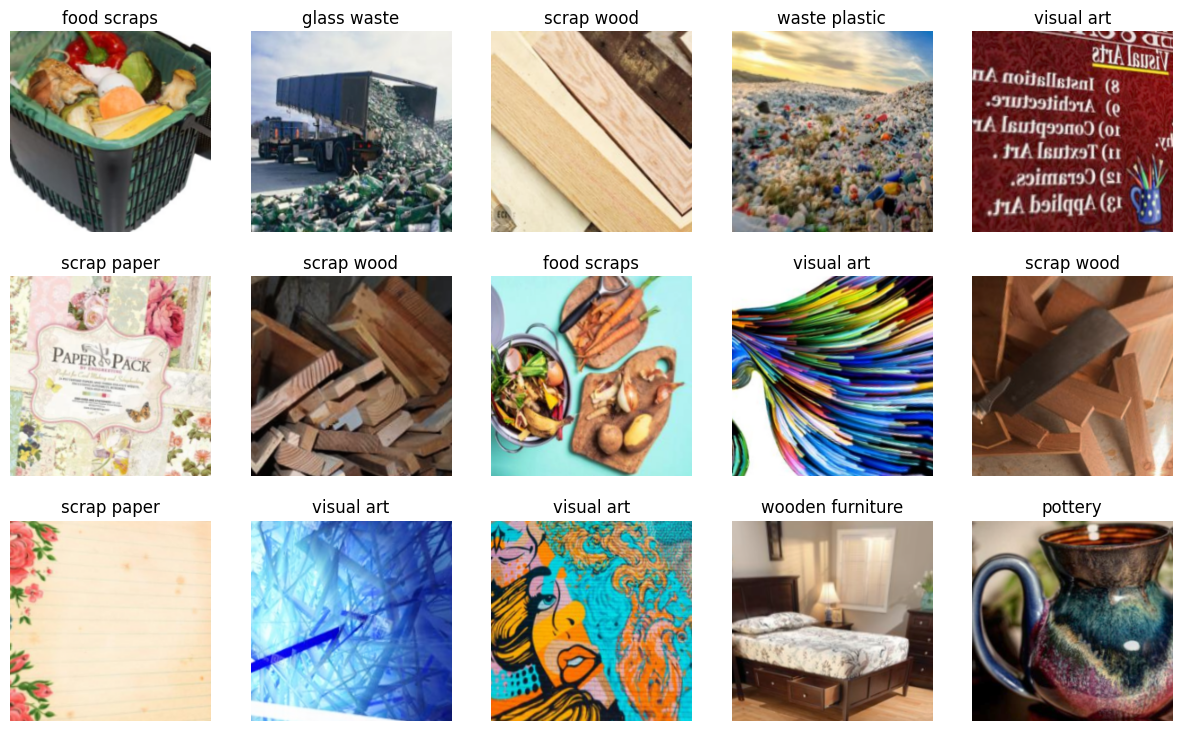

In [10]:
art_or_trash.train.show_batch(max_n=15, nrows=3, unique=False)

### Traning A Fine Tuned Model 

In [11]:
learn = vision_learner(art_or_trash, arch=resnet34, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\katle/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:20<00:00, 4.20MB/s]


### Error Interpretation

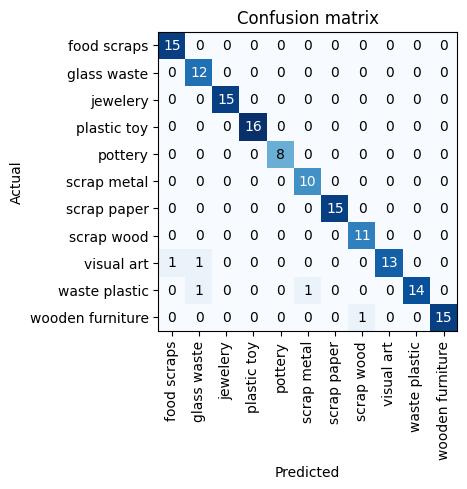

In [12]:

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

c:\Users\katle\anaconda3\envs\dl_env\Lib\site-packages\fastai\torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


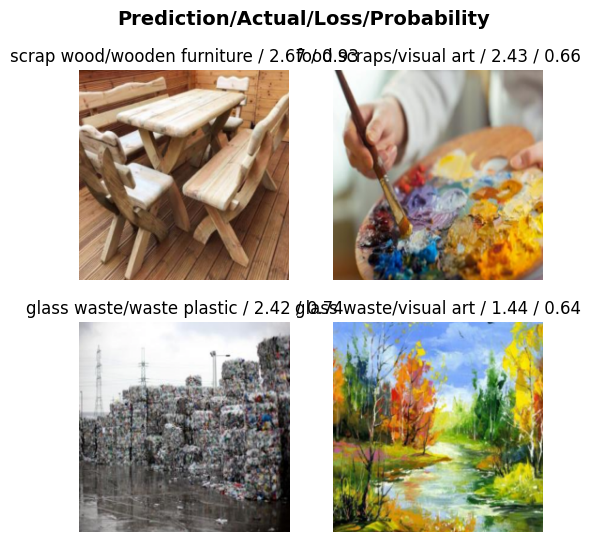

In [13]:
interp.plot_top_losses(4, nrows=2)

In [33]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

c:\Users\katle\anaconda3\envs\dl_env\Lib\site-packages\fastai\torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

In [ ]:
art_or_trash = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.25, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
).dataloaders(path, bs=32)

art_or_trash.train.show_batch(max_n=5, nrows=1, unique=True)

In [26]:
learn = vision_learner(art_or_trash, arch=resnet34, metrics=error_rate)
learn.fine_tune(3)

### Saving The Model

In [23]:
with open('model.pkl', 'wb') as f:
    pickle.dump(learn, f)

In [24]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('model.pkl')]

In [ ]:
learn_inf = load_learner(path/'model.pkl')

In [ ]:
learn_inf.predict('plastic waste.jpg')